In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


**IMPORTS**

In [3]:
import numpy as np 
import pandas as pd 

import torch

import matplotlib.pyplot as plt
import seaborn as sns
import bz2

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from scipy.special import softmax

from tqdm.notebook import tqdm

# add this for pandas, to better look at the data
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

**LOADING DATA**

In [4]:
NO_OF_LINES = 2000

data = {}

for i,line in enumerate(bz2.open("/kaggle/input/amazonreviews/train.ft.txt.bz2", "rt", encoding="utf8")):
    
    if i == NO_OF_LINES:
        break
        
    #Defining Labels
    label = 1 if line[:10] == "__label__1" else 2
    text = line[10:]
    
    localResult = {
        "label": label,
        "text": text
    }
    
    data[i] = localResult
    
df = pd.DataFrame(data).T
df = df.reset_index().rename(columns= {"index": "Id"})
        

**Data Visualization**

    Id label                                               text
0    0     2   Stuning even for the non-gamer: This sound tr...
1    1     2   The best soundtrack ever to anything.: I'm re...
2    2     2   Amazing!: This soundtrack is my favorite musi...
3    3     2   Excellent Soundtrack: I truly like this sound...
4    4     2   Remember, Pull Your Jaw Off The Floor After H...
5    5     2   an absolute masterpiece: I am quite sure any ...
6    6     1   Buyer beware: This is a self-published book, ...
7    7     2   Glorious story: I loved Whisper of the wicked...
8    8     2   A FIVE STAR BOOK: I just finished reading Whi...
9    9     2   Whispers of the Wicked Saints: This was a eas...
10  10     1   The Worst!: A complete waste of time. Typogra...
11  11     2   Great book: This was a great book,I just coul...
12  12     2   Great Read: I thought this book was brilliant...
13  13     1   Oh please: I guess you have to be a romance n...
14  14     1   Awful beyond belief!: I f

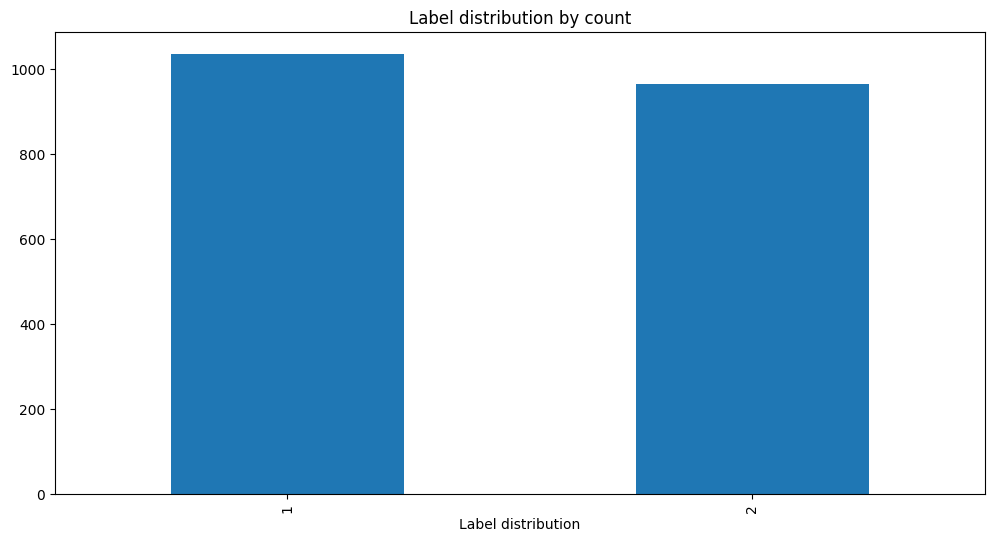

In [5]:
print(df.head(20))

print("the shape of the data", df.shape)

print("unique labels", df["label"].unique())

valueCounts = df["label"].value_counts().sort_index()
print(valueCounts)

ax = valueCounts.plot(kind="bar", title="Label distribution by count", figsize=(12, 6))
ax.set_xlabel("Label distribution")
plt.show()

**Training and Prediction with RoBERTa Transformer**

In [6]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

modelName = "cardiffnlp/twitter-roberta-base-sentiment"

myTokenizer = AutoTokenizer.from_pretrained(modelName, max_length = 512)
myModel = AutoModelForSequenceClassification.from_pretrained(modelName, max_length=512).to(device)

robertaResults = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text"]

    # first we create the tokens from the input text
    tokens = myTokenizer.__call__(text, return_tensors="pt", max_length=512, truncation=True).to(device)

    # next we apply the tokens to our model
    out = myModel.__call__(**tokens)
    
    # here we get the actual scores from the tensors
    scores = out[0][0].detach().cpu().numpy()

    # the scores don't have softmax apply, so we must apply it
    # there are three values, the first is the negative, neutral, positive
    softScores = softmax(scores)

    # create a map with the results
    robertaScores = {
        "roberta_negative": softScores[0],
        "roberta_neutral": softScores[1],
        "roberta_positive": softScores[2],
        "predicted_label": 1 if softScores[0] > softScores[2] else 2
    }

    robertaResults[i] = robertaScores

robertaDf = pd.DataFrame(robertaResults).T

robertaDf = robertaDf.reset_index().rename(columns= {"index": "Id"})

sentimentDf = robertaDf.merge(df, how="left")

print(sentimentDf.head())

Using device: cuda


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/2000 [00:00<?, ?it/s]

   Id  roberta_negative  roberta_neutral  roberta_positive  predicted_label label                                               text
0   0          0.003489         0.014600          0.981911              2.0     2   Stuning even for the non-gamer: This sound tr...
1   1          0.009733         0.052165          0.938101              2.0     2   The best soundtrack ever to anything.: I'm re...
2   2          0.004801         0.020830          0.974369              2.0     2   Amazing!: This soundtrack is my favorite musi...
3   3          0.001495         0.025328          0.973177              2.0     2   Excellent Soundtrack: I truly like this sound...
4   4          0.001908         0.017632          0.980459              2.0     2   Remember, Pull Your Jaw Off The Floor After H...


**Plotting the Result**

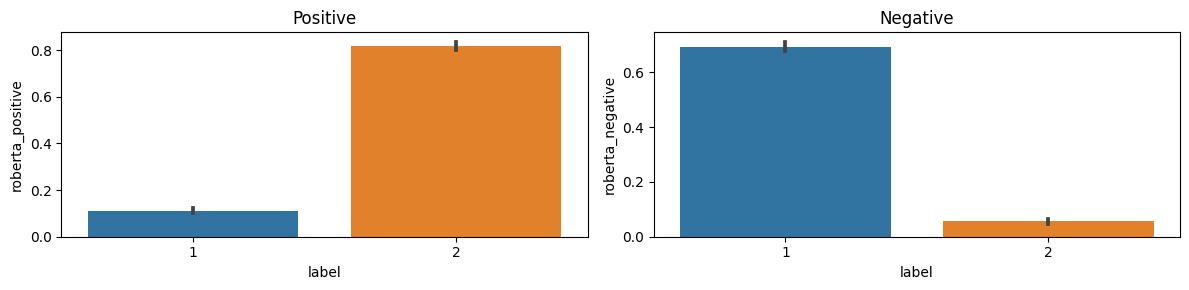

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(data=sentimentDf, x='label', y='roberta_positive', ax=axs[0])
sns.barplot(data=sentimentDf, x='label', y='roberta_negative', ax=axs[1])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.tight_layout()
plt.show()

**Accuracy Calculation**

In [8]:
correct = 0

for i, row in sentimentDf.iterrows():

    if row["label"] == int(row["predicted_label"]):
        correct += 1


accuracy = correct / len(sentimentDf)
print(f"accuracy is {accuracy}")

accuracy is 0.9065
